# Module Load

In [3]:
import h5py, math, cmath, scipy, random, os, csv, pathlib, matplotlib

from mpmath import *

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.optimize import curve_fit
from matplotlib import rcParams, rc, cm, colors
from sklearn.decomposition import PCA
from scipy.stats import skew, poisson, kurtosis 
from matplotlib.font_manager import FontProperties
from scipy.ndimage import gaussian_filter, median_filter, sobel
from scipy.interpolate import griddata
from scipy.signal.signaltools import wiener
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
from scipy.special import sph_harm, lambertw, gamma, factorial
from scipy import interpolate

import scipy.integrate as integrate
import matplotlib.tri as tri
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import scipy.special as sp
import time as timeCheck

plt.style.use('classic')
%matplotlib inline
rcParams['font.family'] = 'Times New Roman'

if 0 : plt.style.use('ggplot')
if 0 : import seaborn as sns; sns.set()

rc('text', usetex=True)
rc('axes', linewidth=2)
rc('font', weight='bold')
# rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
rcParams = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
 
path_local = str(pathlib.Path().absolute())
print('path_local = ',path_local)

path_local =  C:\Users\nickd\OneDrive\Documents\GitHub\PFURO-2023-PRIV\Code


C:\Users\nickd\AppData\Local\Temp\ipykernel_16744\2580724601.py:13: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


# Parameters (REORGANIZE!)

## Physics Constants

In [4]:
um = 10**-6 # m
nm = 10**-9 # m
ns = 10**-9 # s
ps = 10**-12 # s
fs = 10**-15 # s
eV = 1.6*10**-19 # J
kelvin_to_eV = 8.621738*10**-5 # eV 
gcm3_to_kgm3 = 10**3 # kg/m^3
J_to_erg = 10**7 # erg
cm3_to_m3 = 0.01**3 # m^3
Wcm2_to_Wm2 = 100**2 # J/m^2/s

mole = 6.02214076*10**23 # unitless, the Avogadro number
amu = 1.66*10**-27 # kg
angstorm = 10**-10 # m
hbar = 1.0545718*10**-34 # J*s
eV = 1.6*10**-19 # J
dyne = 10**-5 # N
massElectron = 9.10938356*10**-31 # kg
eCharge = 1.602176634*10**-19 # C
eCharge_ESU = 4.80326*10**-10 # esu
kB = 1.380649*10**-23 # J/K
lightSpeed = 299792458.000000 # m/s
vacuumPermittivity = 8.854187817000000E-012 # C⋅V−1⋅m−1 or C^2/N/m^2

## Laser Parameters

In [5]:
# 800
# 355

## Aluminum Parameters

## CH Parameters

## Sapphire Parameters

In [6]:
J_per_mole_per_K = 1/mole/kelvin_to_eV/eV
print('J_per_mole_per_K = ',J_per_mole_per_K)

# Sapphire material properties
Debye_Temp = 1042 # K
Melting_Point_Celsius = 2040 # C
Melting_Point = Melting_Point_Celsius + 273.15 # K
Molar_Mass = 101.961276 # g/mol
Density = 3.98 # g/cm^3
Molar_Volume = Molar_Mass/Density # cm^3/mol
Bulk_Modulus = 240 # GPa
Thermal_Exp_Coef = 5.5*10**(-6) # 1/K
lattice_constant_aAxis = 4.758*angstorm # m 
lattice_constant_cAxis = 12.99*angstorm # m
lattice_constant = max(lattice_constant_aAxis,lattice_constant_cAxis)
kBZ = 2*np.pi/lattice_constant # 1/m

# Sapphire electron-phonon scattering properties
massElectronReduced = massElectron*0.5 # kg
Upotential = 19*eV # J
omega_LO = 2*np.pi*12.6*10**12 # 1/s
varepsilon_infty = 3.038 # || c axis
varepsilon_0 = 11.11 # || c axis

# Sapphire ionization properties
Al_mass = 26.981539*amu # kg
O_mass = 15.999*amu # kg
Sapphire_mass = 2*Al_mass + 3*O_mass # kg
Z_Al = 3
Z_O = 2
Z_total = Z_O + Z_Al # Al2O3
Z_eff = Al_mass/Sapphire_mass*Z_Al*2 + O_mass/Sapphire_mass*Z_O*3
M_eff = massElectron*Sapphire_mass/(massElectron+Sapphire_mass) # kg

melting_point_Sapphire = 2072+273.13 # degree celsius
melting_point_Aluminum = 660.3+273.13 # degree celsius
melting_point_Hydrogen = -259.2+273.13 # degree celsius
melting_point_CH = 249+273.13 # degree celsius

# Laser Parameters
wavelength_800nm = 800*nm
wavelength_355nm = 355*nm
wavelength_351nm = 351*nm
# input  laser intensity unit : W/m^2
# output electric field  unit : V/m
vacuumRefractiveIndex = 1
coef_laserI_eField = (2/lightSpeed/vacuumPermittivity/vacuumRefractiveIndex)**0.5
omega_800nm = lightSpeed/wavelength_800nm*2*np.pi
omega_355nm = lightSpeed/wavelength_355nm*2*np.pi
omega_351nm = lightSpeed/wavelength_351nm*2*np.pi
Eg_Sapphire = 8.8*eV # J  Bandgap
Eg_CH = 4.05*eV # J
sigma2 = 7*10**8 # cm.s/J^2
E_800nm = hbar*omega_800nm # J

rho = Density*gcm3_to_kgm3 # kg/m^3
bulk_modulus = Bulk_Modulus*10**9 # Pa
ni = rho/Sapphire_mass # 1/m^3
n_vb = ni*Z_total # 1/m^3

n_Al_liquid = 1.98
k_Al_liquid = 7.16

skin_length_Al_liquid = lightSpeed/(omega_800nm*k_Al_liquid)
print('skin_length_Al_liquid [nm] = ',skin_length_Al_liquid/nm)

print('hbar*omega_LO/eV = ',hbar*omega_LO/eV)
print('Z_eff = ',Z_eff)
print('M_eff = ',M_eff)
print('Sapphire_mass = ',Sapphire_mass)
print('ni = ',ni)
print('E_800nm/eV = ',E_800nm/eV)
print('omega_800nm = ',omega_800nm)
print('omega_355nm = ',omega_355nm)
print('omega_355nm/omega_800nm = ',omega_355nm/omega_800nm)

print('melting_point_Aluminum (meV) = ',round(melting_point_Aluminum*kelvin_to_eV*1000,1))
print('melting_point_Sapphire (meV) = ',round(melting_point_Sapphire*kelvin_to_eV*1000,1))
print('melting_point_Hydrogen (meV) = ',round(melting_point_Hydrogen*kelvin_to_eV*1000,1))
print('melting_point_CH (meV)       = ',round(melting_point_CH*kelvin_to_eV*1000,1))

J_per_mole_per_K =  0.12037444387473313
skin_length_Al_liquid [nm] =  17.782675205798366
hbar*omega_LO/eV =  0.05218030155811667
Z_eff =  2.529256931325612
M_eff =  9.109334532765864e-31
Sapphire_mass =  1.6925372948e-25
ni =  2.351499144053012e+28
E_800nm/eV =  1.5519107999294668
omega_800nm =  2354564459136066.0
omega_355nm =  5306060752982685.0
omega_355nm/omega_800nm =  2.253521126760564
melting_point_Aluminum (meV) =  80.5
melting_point_Sapphire (meV) =  202.2
melting_point_Hydrogen (meV) =  1.2
melting_point_CH (meV)       =  45.0


# Heat Capacity (From Jack: Al and CH)

We have this

Concept for IPF is lattice vibration. The system will have internal energy that eventually becomes a harmonic oscillator.  U = Estein model for heat capacity.

Eventually heat capacity just C_ve = dU/dT

Laser will oscillate electrons and electrons will be oscilalting in polarizaation direction which will then hit the ion so when the electron collides with the ions. Driving oscillator problem cause then the whole system will start vibrating which will have eigen frequency. Basically we have two types of oscillations (acoustic and polar optical phonons).

Acoustic phonon = long wavelength perturbation (transport sound waves or the SHOCK in our case also transports heat). Means a small 'k' (wave vector).

Polar optical phonon = (in lattice, two atoms will move molecules and produce some charge separation, so they will have some residual charge to make them become polar. So they become quasi polar molecules which carry some residual charge which will later on interact with Electric field (WE HAVE THIS IN CH).

Aluminum has acoustic mode, CH has polar and acoustic mode because of their specific lattice structure. 

Polar -- dipole moments

Polar is short wavelength

Aluminum has a fcc shappe (conal) and each 

phonon = vibrational mode in lattice vibration = eigenfrequency type = quantum concept to describe lattice vibration

Ion = plasma in our model.
Lattice = bounded nucleus on solid state before goes into plasma

## get_Cp_exp

In [7]:
def get_Cp_exp():
    
    # https://polymerdatabase.com/polymer%20physics/CpPS.html
    # Cp - Cv (J/mol/K) = MolarVolume(m^3/mole) * ThermalExp(1/K)**2 * BulkModulus(Pa) * Temperature(K)
    # correction term (J/mol/K)
    
    filename = '\Sapphire_Heat_Capacity.csv'
    file_to_open = open(path_local+filename,'r')

    Cp_data = []
    for line in file_to_open:
        row = line.split(',')
        #print([float(ele) for ele in row])
        Cp_data.append([float(ele) for ele in row])
    Cp_data = np.array(Cp_data)
    
    return Cp_data

# this data is needed for get_Cp_exp_fit
Cp_data = get_Cp_exp()

## get_Cp_exp_fit

<Figure size 640x480 with 0 Axes>

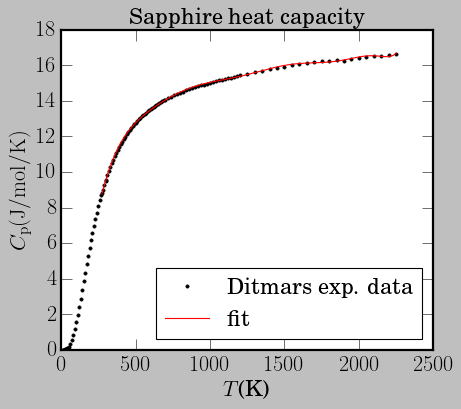

In [8]:
def get_Cp_exp_fit(Ti):
    
    # T : kelvein

    def func(x,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10):
        return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5+a6*x**6+a7*x**7+a8*x**8+a9*x**9+a10*x**10

    xdata = Cp_data[:,0]
    ydata = Cp_data[:,1]    
    popt, pcov = curve_fit(func, xdata, ydata)
    a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10 = popt
    
    return func(Ti,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10) # J/mol/K

if 1 :
    # begin the fit
    T_initial = 273.15
    T_final   = Cp_data[-1,0]
    xdata_fit = np.array([T for T in np.arange(T_initial,T_final,1)])
    ydata_fit = np.array([get_Cp_exp_fit(T) for T in xdata_fit])

    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5))
    fs = 20
    ax.plot(Cp_data[:,0],Cp_data[:,1]*J_per_mole_per_K,'.',c='k',label='Ditmars exp. data')
    ax.plot(xdata_fit,ydata_fit*J_per_mole_per_K,label='fit',c='r')

    ax.legend(numpoints=1,fontsize=fs,loc='lower right')
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T$(K)',fontsize=fs)
    ax.set_ylabel(r'$C_\mathrm{p}\mathrm{(J/mol/K)}$',fontsize=fs)
    ax.set_title(r'Sapphire heat capacity',fontsize=fs)

## get_Cv_exp_fit

In [ ]:
def get_Cv_exp_fit(Ti):
    
    # Ti : kelvein

    def func(x,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10):
        return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5+a6*x**6+a7*x**7+a8*x**8+a9*x**9+a10*x**10

    xdata = Cp_data[:,0]
    ydata = Cp_data[:,1]    
    popt, pcov = curve_fit(func, xdata, ydata)
    a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10 = popt
    
    # Molar_Volume : cm^3/mole
    # Thermal_Exp_Coef : 1/K
    # Bulk_Modulus : GPa
    # The factor 1000 is to convert cm^3*GPa into m^3*Pa = J
    
    Cp = func(Ti,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10) # J/mol/K
    correction = Molar_Volume*Thermal_Exp_Coef**2*Bulk_Modulus*Ti*1000 # J/mol/K
    
    return Cp - correction # J/mol/K

if 1 :
    # begin the fit
    T_initial = 273.15
    T_final   = Cp_data[-1,0]
    xdata_fit = np.array([T for T in np.arange(T_initial,T_final,1)])
    ydata_fit = np.array([get_Cp_exp_fit(T) for T in xdata_fit])
    ydata_fit2= np.array([get_Cv_exp_fit(T) for T in xdata_fit])

    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5))
    fs = 20
    ax.plot(Cp_data[:,0],Cp_data[:,1]*J_per_mole_per_K,'.',c='k',label='Ditmars exp. data')
    ax.plot(xdata_fit,ydata_fit*J_per_mole_per_K,label='Cp fit',c='r')
    ax.plot(xdata_fit,ydata_fit2*J_per_mole_per_K,label='Cv fit',c='b')

    ax.legend(numpoints=1,fontsize=fs,loc='lower right')
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T$(K)',fontsize=fs)
    ax.set_ylabel(r'$C_\mathrm{p}\mathrm{(J/mol/K)}$',fontsize=fs)
    ax.set_title(r'Sapphire heat capacity',fontsize=fs)

## get_Cv_theory (Debye model)

In [ ]:
def get_Cv_theory(Ti):
    
    # http://hyperphysics.phy-astr.gsu.edu/hbase/Solids/phonon.html

    natoms = 5

    TD = Debye_Temp*kelvin_to_eV*eV
    
    def func(x):
        return x**4*math.exp(x)/(math.exp(x)-1)**2
    
    r1 = integrate.quad(lambda x: func(x),0,TD/Ti)[0]
    
    C = 9*(Ti/TD)**3*r1
    
    if Ti/(kelvin_to_eV*eV) > Melting_Point : C = 1.5
    
    if 0 :
        print('Ti = ',Ti/(kelvin_to_eV*eV))
        print('C  = ',C)
        
    return C*natoms*mole*kB # J/mole/K

lattice_T = np.array([Ti*kelvin_to_eV*eV for Ti in np.arange(10,Melting_Point,10)])
Cv_theory = np.array([get_Cv_theory(Ti) for Ti in lattice_T])

plt.figure()
fig, ax = plt.subplots(figsize=(6,5))
fs = 20

#ax.plot(Cp_data[:,0],Cp_data[:,1],'.',c='k',label='Ditmars exp. data')
ax.plot(Cp_data[:,0],Cp_data[:,1]-Molar_Volume*Thermal_Exp_Coef**2*Bulk_Modulus*Cp_data[:,0]*1000,'.',c='k',label='Ditmars exp. data')  
ax.plot(lattice_T/(kelvin_to_eV*eV),Cv_theory,c='r',label='Debye model')

ax.tick_params(which='major',length=10,labelsize=fs)
ax.set_xlabel(r'$T$(K)',fontsize=fs)
ax.set_ylabel(r'$C_\mathrm{V}\mathrm{(J/mol/K)}$',fontsize=fs)
ax.set_title(r'Sapphire heat capacity',fontsize=fs)
ax.legend(numpoints=1,fontsize=fs,loc='lower right')

# Electron-Phonon Collision Rates

What matters is the rate of momentum relaxation. So when electron collides with particle you want and eventually they have some momentum which eventually relaxes. Which means electron momentum transfers to other particles. So we calculate average time to relax and excited electron state to equilibrium.

Transition from ground state to excited state and how long it takes for electron to relax.
Collision frequency called V_c which we eventually multiply by some parameter to define collision frequency in Energy and not in momentum.


This module will eventually help us get 'G' which is the relaxations scale.

## get_g_DOS

In [ ]:
def get_g_DOS(E):
    
    if E<0 :
        print('>>> get_g_DOS : negative E detected, STOP')
        import sys
        sys.exit()
    
    # M. Lundstrom "Fundamental of Carrier Transport", P.48, Eq.(2.9)
    
    return (2*massElectronReduced)**(3/2)/(2*np.pi**2*hbar**3)*np.sqrt(E)
    
get_g_DOS(eV)    

## get_vc_DAC (Deformation Acoustic potential interaction)

In [ ]:
def get_vc_DAC(rho,Ti,Te):
    
    # M. Lundstrom "Fundamental of Carrier Transport", P.68, Eq.(2.66)
        
    cs = np.sqrt(bulk_modulus/rho) # m/s
    
    # elastic constant
    cl = rho*cs**2
               
    vc_Lundstorm = np.pi*Upotential**2*Ti/(hbar*cl)*get_g_DOS(Te) # 1/s
        
    if 0 : 
        print('>>> get_vc_DAC ...')
        print('cs = ',cs)
        print('vc_Lundstorm = ',"{:.3e}".format(vc_Lundstorm))
    
    return vc_Lundstorm # 1/s

if 1 : 
    Ti = 0.01*eV
    temp = np.array([T for T in np.arange(0.01,Melting_Point*kelvin_to_eV,0.005)])
    vc_DAC = np.array([get_vc_DAC(rho,Ti,Te*eV)*10**(-13) for Te in temp])
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5.5))
    fs,fs2 = 20,15
    ax.plot(temp,vc_DAC,lw=2,c='k')    

    #ax.legend(numpoints=1,fontsize=fs,loc='lower right')
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T_\mathrm{e}$(eV)',fontsize=fs)
    ax.set_ylabel(r'Scattering rate ($10^{13}$ 1/s)',fontsize=fs)
    ax.set_title(r'Sapphire deformation '+'\n'+'acoustic phonon scatterings',fontsize=fs)
    #ax.grid(True)

## get_vc_POP_Lundstorm (Polar Optical)

In [ ]:
def get_vc_POP_Lundstorm(Te,omega_LO,Ti):
        
    # omega_LO : 1/s
    # Ti : J
    # Te : J
    
    E_e = 3/2*Te # J
    
    # M. Lundstrom "Fundamental of Carrier Transport", P.39, Eq.(2.83)
    
    E_p = hbar*omega_LO # J

    factor1 = eCharge**2*omega_LO/(4*np.pi*hbar)/np.sqrt(2*E_e/massElectronReduced)
    factor2 = (1/varepsilon_infty - 1/varepsilon_0)/vacuumPermittivity
    
    # Bose-Einstein factor
    # M. Lundstrom "Fundamental of Carrier Transport", P.39, Eq.(1.113)
    g_LO = 1/(math.exp(E_p/Ti)-1)
    
    part1 = g_LO*np.sqrt(1+E_p/E_e)
    
    if E_p/E_e < 1 :
        part2 = (g_LO+1)*np.sqrt(1-E_p/E_e)
    else :
        part2 = 0
        
    part3 = E_p*g_LO/E_e*np.arcsinh(np.sqrt(E_e/E_p))
    
    if E_e/E_p > 1 :
        part4 = E_p*(g_LO+1)/E_e*np.arcsinh(np.sqrt(E_e/E_p-1))
    else :
        part4 = 0
      
    vc_POP_Lundstorm = factor1*factor2*(part1+part2-part3+part4)
    
    if 0 :
        #print('>>> get_EOP_rate ...')
        print('E_p/meV = ',E_p/meV)
        print('E_e/meV = ',E_e/meV)
        print('E_e/E_p = ',E_e/E_p)        
        print('omega_LO = ',omega_LO) 
        print('factor1 = ',factor1) 
        print('factor2 = ',factor2) 
        print('g_LO = ',g_LO)  
        print('part1 = ',part1)
        print('part2 = ',part2)
        print('part3 = ',part3)
        print('part4 = ',part4)  
    
    return vc_POP_Lundstorm # 1/s

Te = 0.025*eV
Ti = 0.025*eV

print('vc_POP_Lundstorm = ',"{:.3e}".format(get_vc_POP_Lundstorm(Te,omega_LO,Ti)))
print('tes : ',"{:.3e}".format(422831425610877.44))
    
if 1 : 
    temp = np.array([T for T in np.arange(0.01,Melting_Point*kelvin_to_eV,0.005)])
    vc_DAC = np.array([get_vc_DAC(rho,Ti,Te*eV)*10**(-14) for Te in temp])
    vc_POP = np.array([get_vc_POP_Lundstorm(Te*eV,omega_LO,Ti)*10**(-14) for Te in temp])
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(7.5,5.5))
    fs,fs2 = 20,15
    ax.plot(temp,vc_DAC,lw=2,c='k',label='Deformation acoustic phonon scatterings')
    ax.plot(temp,vc_POP,lw=2,c='r',label='Polar optical phonon scatterings')

    ax.legend(numpoints=1,fontsize=fs2,loc='center',bbox_to_anchor=[.9,.3])
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T_\mathrm{e}$(eV)',fontsize=fs)
    ax.set_ylabel(r'Scattering rate ($10^{14}$ 1/s)',fontsize=fs)
    ax.set_title('Optical phonon energy = 0.052 eV',fontsize=fs)
    #ax.grid(True)
    ax.grid(b=True, which='major', color='grey', linestyle='--')  

# Coulomb Logarithm

## get_nc

In [ ]:
def get_nc(wavelength):
    
    # input wavelength unit : m
    # output nc unit        : 1/m^3
    
    angular_freq = 2*math.pi*(lightSpeed/wavelength)
    ne_crit = vacuumPermittivity*massElectron*angular_freq**2/eCharge**2
    return ne_crit # (1/m^3)

nc_800nm = get_nc(wavelength_800nm) # 1/m^3
print('nc_800nm [1/cm^3] = ',nc_800nm/10**6)

## get_E_Fermi

In [ ]:
def get_E_Fermi(ne):

    # P. 198 Statistical Mechanics Eq. (24)
    
    # ne : 1/m^3
    # massElectron : kg
    
    # weight factor arising from internal structure e.g. spin
    g = 2
    
    EF = hbar**2/(2*massElectron)*(6*np.pi**2*ne/g)**(2/3) # J
        
    return EF # J

E_Fermi_800nm = get_E_Fermi(ne=nc_800nm)

print('E_Fermi_800nm/eV = ',"{:.3e}".format(E_Fermi_800nm/eV))

## get_lambda_DH

In [ ]:
def get_lambda_DH(Te,Ti,ne,ni):
        
    # Te : J
    # Ti : J  
    # ne : 1/m^3
    # ni : 1/m^3
    
    E_Fermi = get_E_Fermi(ne) # J    
    T_Fermi = E_Fermi*2/3     # J
    
    Te_erg = Te*J_to_erg      # erg
    Ti_erg = Ti*J_to_erg      # erg
    Tf_erg = T_Fermi*J_to_erg # erg
    
    ne_gcc = ne/gcm3_to_kgm3  # g/cm^3
    ni_gcc = ni/gcm3_to_kgm3  # g/cm^3
        
    part1 = 4*np.pi*ne_gcc*eCharge_ESU**2/np.sqrt(Te_erg**2+Tf_erg**2)
    part2 = 4*np.pi*ni_gcc*eCharge_ESU**2*Z_total**2/Ti_erg
    
    lambda_DH_cm = (part1 + part2)**(-1/2)     # cm
    lambda_DH    = (part1 + part2)**(-1/2)/100 # m    
    
    if 0 : 
        print(' >>> get_lambda_DH ... ')    
        print('E_Fermi/eV = ',"{:.3e}".format(E_Fermi/eV))
        print('T_Fermi/eV = ',"{:.3e}".format(T_Fermi/eV))    
        print('part1 = ',"{:.3e}".format(part1))
        print('part2 = ',"{:.3e}".format(part2))    
        print('lambda_DH (m) = ',"{:.3e}".format(lambda_DH),"{:.3e}".format(3.0633571046391684E-014)) 
    
    return lambda_DH # m
    
get_lambda_DH(0.025*eV,0.025*eV,10**22*100**3,3*10**22*100**3)    

## get_R_cloest

In [ ]:
def get_R_cloest(Te,Ti,ne,ni):
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni) # m
    
    w = lambertw(2*Z_total*eCharge**2/(lambda_DH*Te)) # unitless
    
    R_cloest = lambda_DH*np.real(w) # m
    
    if 0 :
        print('>>> get_R_cloest ... ')    
        print('lambda_DH (m) = ',lambda_DH)
        print('w, np.real(w) = ',w,np.real(w))
        print('R_cloest  (m) = ',R_cloest)
    
    return R_cloest # m
    
get_R_cloest(Te,Ti,10**22*100**3,10**22*100**3)

## get_R_Broglie

In [ ]:
def get_R_Broglie(Te):    
    
    R_Broglie = hbar*(2*np.pi)/np.sqrt(massElectron*Te) # m
    
    if 0 : 
        print(' >>> get_R_Broglie ... ')    
        print('R_Broglie = ',R_Broglie)
    
    return R_Broglie # m
    
get_R_Broglie(0.025*eV)    

## get_Coulomb_Log0

In [ ]:
def get_Coulomb_Log0(Te,ne):
    
    # Te : J
    # ne : 1/m^3
         
    Debye_length = np.sqrt(vacuumPermittivity*Te/ne/(Z_eff*eCharge)**2) # m
    
    Impact_length = (Z_eff*eCharge)**2/(4*np.pi*vacuumPermittivity)/(3*Te)
    
    Broglie_length = hbar*(2*np.pi)/np.sqrt(massElectron*Te) # m
    
    bmin = min(Broglie_length,Impact_length)
    bmax = Debye_length
    
    Coulomb_Log = max(np.log(bmax/bmin),1)
    
    if 0 :
        print('Debye_length = ',Debye_length)
        print('Impact_length = ',Impact_length)
        print('Broglie_length  = ',Broglie_length)
        print('Coulomb_Log = ',Coulomb_Log,np.log(bmax/bmin))
        
    return Coulomb_Log
    
get_Coulomb_Log0(Te=1*eV,ne=10**26)    

## get_Coulomb_Log

In [ ]:
def get_Coulomb_Log(Te,Ti,ne,ni):
         
    R_cloest = get_R_cloest(Te,Ti,ne,ni)*0
    
    R_Broglie = get_R_Broglie(Te)
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni)
    
    ai = (3/(4*np.pi*ni))**(1/3) # m
    
    bmin = 0.5 * max(R_cloest, R_Broglie) # m
        
    bmax = np.sqrt(lambda_DH**2+ai**2) # m
    
    Coulomb_Log = max(1/2*np.log(1+bmax**2/bmin**2),1)
        
    if 0 : 
        print('>>> get_Coulomb_Log ... ')        
        print('R_cloest  (m) = ',R_cloest)
        print('R_Broglie (m) = ',R_Broglie)
        print('bmin (m)      = ',bmin) 
        print('lambda_DH (m) = ',lambda_DH)
        print('ai (m)        = ',ai) 
        print('bmax (m)      = ',bmax)
        print('Coulomb_Log   = ',Coulomb_Log)
        
    return Coulomb_Log
    
get_Coulomb_Log(0.025*eV,0.025*eV,10**22*100**3,3*10**22*100**3)     

# Plasma Collision Frequency

Plasma frequency is before light waves go inside material

## get_mu (mu is chemical potential)

In [ ]:
def get_mu(ne,Te):
    
    #print('>>> get_mu ... ')  
    
    #To sum up, to increase the number of particles of a classical gas keeping the       volume and entropy constant, you have to change the energy of the system by a negative amount. This change in the energy (which is negative) is the chemical potential of the classical gas.
        
    # ne : 1/m^3
    # Te : J
    
    y = hbar**3*np.pi**2*ne/np.sqrt(2)/(massElectron*Te)**(3/2)
    
    #print('y = ',y)
    
    a  = 15
    y0 = 1.52
    
    if y < 1 :        
        inside = 4*y/(2*np.pi**0.5-y)        
        mu = Te*np.log(inside)
        
    if (y >= 1) and (y<2.5) :
        inside1 = 4*y/(2*np.pi**0.5-y)
        inside2 = (3*y/2)**(4/3)-np.pi**2/6
        denominator1 = 1+math.exp( a*(y-y0))
        denominator2 = 1+math.exp(-a*(y-y0))        
        mu = Te*(np.log(inside1)/denominator1+np.sqrt(inside2)/denominator2)
        #print(inside1,inside2)
        #print(denominator1,denominator2)
        #print(mu)
        
    if y >= 2.5 :
        inside = (3*y/2)**(4/3)-np.pi**2/6
        mu = Te*np.sqrt(inside)
    
    #print('get_mu : mu_eV = ',mu/eV,', Te_eV = ',Te/eV,', y = ',y)
    
    return mu # J

#temp = [ T for T in np.arange(0.01,100,0.01)]
#mu = [get_mu(10**22*100**3,Te*eV)/eV for Te in temp]
#plt.plot(temp,mu)
get_mu(10**22*100**3,0.25*eV)
get_mu(10**22*100**3,0.90*eV)
get_mu(10**22*100**3,1.90*eV)

## Fermi_Dirac

In [ ]:
def Fermi_Dirac(s,x): 
    #print(s+1,-math.exp(x))
    return -gamma(s+1)*polylog(s+1,-math.exp(x))
    #return -gamma(s+1)
    #return polylog(s+1,-math.exp(x))

print(polylog(1,0.5))
print(gamma(1.5))
Fermi_Dirac(1,.00001)

## get_mu_new

In [ ]:
def get_mu_new(ne,Te):
    
    y = hbar**3*np.pi**2*ne/np.sqrt(2)/(massElectron*Te)**(3/2)

    def integration(x):
        return integrate.quad(lambda t : t**0.5/(math.exp(t-x)+1), 0, 10**2)[0]

    def func(x):
        s = 0.5
        return Fermi_Dirac(s,x).real - y

    sol = scipy.optimize.root(func, 0, method='lm')
    y_inverted = sol.x[0]
    #print('y = ',y,'y_inverted = ',y_inverted)
    
    mu = y_inverted*Te # J
    
    return mu # J

ne = 10**19*100**3
Te = 2*eV
print('mu_new = ',get_mu_new(ne,Te)/eV)
print('mu     = ',get_mu(ne,Te)/eV)

## get_FD_integral

In [ ]:
def get_FD_integral(x):
        
    FD_integral = integrate.quad(lambda t:t**0.5/(1+math.exp(t-x)),0,100)[0]
    
    if 0 : 
        print(' >>> get_FD_integral ... ')
        print(' FD_integral ',FD_integral)
    
    return FD_integral
    
get_FD_integral(0.1)    

## get_vc_ion

In [ ]:
def get_vc_ion(Te,Ti,ne,ni,degeneracy):

    ne_gcc = ne/100**3 # g/cm^3
    
    Te_eV = Te/eV # eV
    
    Coulomb_Log = get_Coulomb_Log(Te,Ti,ne,ni) # unitless
            
    Zlnlambda = Coulomb_Log
    # Ref[NRL : all quantities in CGS except Te in eV]
    vei_NRL = 2.91*10**-6*ne_gcc*Zlnlambda/(Te_eV**1.5) # 1/s with unit [Te] in eV    
    
    part1 = np.sqrt(2/np.pi)/3
    part2 = ((Z_total*eCharge**2)/(4*math.pi*vacuumPermittivity))**2
    part3 = (4*math.pi)/(massElectron**.5*Te**1.5)
    vei_Standard = part1 * ni * part2 * part3 * Zlnlambda 

    if degeneracy == 2 : vc_ion = vei_NRL
    if degeneracy == 3 : vc_ion = vei_Standard
    
    if 0 : 
        print('>>>> get_vc_ion ...')
  
        print('vei_NRL = ',vei_NRL)
        print('vei_Standard = ',vei_Standard)    
     
        
    return vc_ion
    
get_vc_ion(0.025*eV,0.025*eV,10**22*100**3,3*10**22*100**3,3) 

if 1 : 
    temp = [ T for T in np.arange(Melting_Point*kelvin_to_eV,10,0.1)]
    vc_ION = [get_vc_ion(T*eV,T*eV,nc_800nm,ni,3)*10**(-21) for T in temp]    
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5.5))
    fs,fs2 = 20,15
    ax.plot(temp,vc_ION,lw=2,c='k')

    #ax.legend(numpoints=1,fontsize=fs2,loc='center',bbox_to_anchor=[.9,.3])
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T_\mathrm{e}$(eV)',fontsize=fs)
    ax.set_ylabel(r'Scattering rate ($10^{21}$ 1/s)',fontsize=fs)
    ax.set_title('Electron-ion collision frequency',fontsize=fs)
    #ax.grid(True)

# Lattice Collision Frequency

## get_vc_neutral

In [ ]:
def get_vc_neutral(Te,ni):
    
    sigma = np.pi*(lattice_constant)**2 # m^2
    
    vc_neutral = ni*sigma*np.sqrt(Te/massElectron) # 1/s
    
    if 0 : 
        print('>>> get_vc_neutral ... ')
        print('vc_neutral = ',"{:.3e}".format(vc_neutral))
    
    return vc_neutral # 1/s
    
get_vc_neutral(0.025*eV,ni) 

if 1 : 
    temp = [ T for T in np.arange(Melting_Point*kelvin_to_eV,10,0.1)]
    vc_NEU = [get_vc_neutral(T*eV,ni)*10**(-17) for T in temp]    
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5.5))
    fs,fs2 = 20,15
    ax.plot(temp,vc_NEU,lw=2,c='k')

    #ax.legend(numpoints=1,fontsize=fs2,loc='center',bbox_to_anchor=[.9,.3])
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T_\mathrm{e}$(eV)',fontsize=fs)
    ax.set_ylabel(r'Scattering rate ($10^{17}$ 1/s)',fontsize=fs)
    ax.set_title('Electron-neutral collision frequency',fontsize=fs)
    #ax.grid(True)

## get_vc

In [ ]:
def get_vc(Te,Ti,ne,ni,rho):
    
    if 0 : 
        print('Te/eV = ',"{:.3e}".format(Te/eV))
        print('Ti/eV = ',"{:.3e}".format(Ti/eV))
        print('ne    = ',"{:.3e}".format(ne))
        print('ni    = ',"{:.3e}".format(ni))        
        print('rho   = ',"{:.3e}".format(rho))           
        
    vc_neutral = get_vc_neutral(Te,ni)        
    
    degeneracy = 3
    
    vc_ion = get_vc_ion(Te,Ti,ne,ni,degeneracy)
    
    Tc = Melting_Point*kelvin_to_eV*eV # J
    
    XPS = (np.tanh(-(Te-Tc))+1)/2
    
    XAM = (np.tanh(+(Te-Tc))+1)/2
    
    ve = math.sqrt(1.5*Te/massElectron) # m/s
    vmpf = ve*ni**(1/3) # 1/s   
        
    if Te<Tc : 
        EAP_rate_avg = get_vc_DAC(rho,Ti,Te)
        POP_rate_avg = get_vc_POP_Lundstorm(Te,omega_LO,Ti)
        vc_new = EAP_rate_avg + POP_rate_avg*1

    if (Te>=Tc) : 
        #vc_new = 1/(1/vc_neutral+1/vc_ion)
        vc_new = 1/(1/vmpf+1/vc_ion)
    
    if 0 : 
        print('>>> get_vc_new ... ')     
        print('EAP_rate_avg (1/s) = ',"{:.3e}".format(EAP_rate_avg))
        print('EOP_rate_avg (1/s) = ',"{:.3e}".format(EOP_rate_avg)) 
        print('vc_neutral (1/s)   = ',"{:.3e}".format(vc_neutral))
        print('vc_ion (1/s)       = ',"{:.3e}".format(vc_ion))
        print('vc_new (1/s)       = ',"{:.3e}".format(vc_new),"{:.3e}".format(1498142804067695.8))
    
    return vc_new
        
get_vc(0.025*eV,0.025*eV,10**22*100**3,3*10**22*100**3,rho) 

if 1 :
    temp = [ T for T in np.arange(0.01,100,0.01)]
    collFreq = [get_vc(T*eV,T*eV,nc_800nm,ni,rho) for T in temp]
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5.5))
    fs,fs2 = 20,15
    ax.loglog(temp,collFreq,lw=2,c='k')

    #ax.legend(numpoints=1,fontsize=fs2,loc='center',bbox_to_anchor=[.9,.3])
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T_\mathrm{e}$(eV)',fontsize=fs)
    ax.set_ylabel(r'Collision frequency (1/s)',fontsize=fs)
    ax.set_title(r'$T_\mathrm{e} = T_\mathrm{i}$',fontsize=fs)
    #ax.grid(True)     

# Heat Transfer

## get_G

In [ ]:
def get_G(Ce,vc):
    
    # input collision frequency unit : 1/s
    # input Ce unit : 1/m^3 
    # output G unit : 1/m^3/s    
    
    #me_to_mil = 1/1836
    me_to_mil = massElectron/min(Al_mass,O_mass)
    #print('me_to_mil = ',me_to_mil,1/1836)
    
    return Ce*vc*me_to_mil #1/m^3/s

Ce = 1.5*get_nc(wavelength_800nm) 
vc=10**15
G = get_G(Ce,vc)
print('G(1/s/m^3) = ',"{:.3e}".format(G))
print('G/Ce/vc = ',"{:.3e}".format(G/Ce/vc))

## get_Sq

In [ ]:
def get_Sq(Te,Ti,q,k):
    
    cs = np.sqrt(bulk_modulus/rho) # m/s
    
    E_ph = hbar*cs*q # J
    E_el = hbar**2*k**2/(2*massElectronReduced) # J
    
    Nq_i = 1/(math.exp(E_ph/Ti)-1)
    Nq_e = 1/(math.exp(E_ph/Te)-1) 
    
    mu = get_mu(ne,Te)
    
    E_Fermi = get_E_Fermi(ne)    
    
    E_el_BZ = hbar**2*kBZ**2/(2*massElectronReduced)
        
    if (E_el-mu)/Te < 100 :
        F_k  = 1/(math.exp((E_el-mu)/Te)+1)
        F_kq = 1/(math.exp((E_el+E_ph-mu)/Te)+1)
    else :
        F_k  = 0
        F_kq = 0
    
    Sq = (F_kq - F_k)*(Nq_i - Nq_e)
    
    if 0 : 
        print('>>> get_Sq ... ')
        print('E_ph/eV = ',E_ph/eV)
        print('E_el/eV = ',E_el/eV)    
        print('Nq_e = ',Nq_e)
        print('Nq_i = ',Nq_i) 
        print('mu/eV = ',mu/eV) 
        print('E_el_BZ/eV = ',E_el_BZ/eV)
        print('E_Fermi/eV = ',E_Fermi/eV)
        print('(E_el-mu)/Te = ',(E_el-mu)/Te)
        print('F_k = ',F_k)
        print('F_kq = ',F_kq)
        print('Sq = ',Sq)
    
    return Sq

ne = 10**22*100**3 # 1/m^3
#ni = n_a_CH # 1/m^3
Te,Ti = 0.0251*eV, 0.025*eV # J    
q = 0.1*2*pi/lattice_constant # 1/m
k = q

get_Sq(Te,Ti,q,k)    

## get_G_ep_DAC

In [ ]:
def get_G_ep_DAC(Te,Ti,rho):
    
    cs = np.sqrt(bulk_modulus/rho) # m/s

    def f(q, k):

        const = Upotential**2*massElectronReduced/(8*np.pi**3*hbar*rho) # J*m^3/s

        if 0 :
            print('const = ',const)
            print('get_Sq(Te,Ti,q,k) = ',get_Sq(Te,Ti,q,k))

        return const*k*q**3*get_Sq(Te,Ti,q,k) # J/s/m

    def bounds_k():
        return [0, kBZ]

    def bounds_q(k):
        return [0, 2*k + 2*massElectronReduced*cs/hbar]
    
    result = integrate.nquad(f, [bounds_q, bounds_k])[0] # J/s/m^3
    
    return result # J/s/m^3

ne = 10**22*100**3 # 1/m^3
Te,Ti = 0.02*eV, 0.025*eV # J  
vc=10**15
G_ep_DAC = get_G_ep_DAC(Te,Ti,rho)

print("{:.3e}".format(G_ep_DAC/(Te-Ti)/(1.5*ne)/vc))

## get_G_ep_POP

In [ ]:
def get_G_ep_POP(Te,Ti,rho,omega_LO):

    def f(q, k):

        factor = (1/varepsilon_infty - 1/varepsilon_0)/vacuumPermittivity  
        const = omega_LO**2*massElectronReduced*eCharge**2/(8*np.pi**3*hbar)*factor

        if 0 :
            print('const = ',const)
            print('get_Sq(Te,Ti,q,k) = ',get_Sq(Te,Ti,q,k))

        return const*k/q*get_Sq(Te,Ti,q,k) # J/s/m

    def bounds_k():
        return [np.sqrt(2*massElectronReduced*omega_LO/hbar), kBZ]

    def bounds_q(k):
        return [k*(1-np.sqrt(1-hbar*omega_LO/(hbar**2*k**2/2/massElectronReduced))),
                k*(1+np.sqrt(1+hbar*omega_LO/(hbar**2*k**2/2/massElectronReduced)))]
    
    result = integrate.nquad(f, [bounds_q, bounds_k])[0] # J/s/m^3
    
    return result # J/s/m^3

ne = 10**22*100**3 # 1/m^3
Te,Ti = 0.01*eV, 0.025*eV # J  
vc=10**15
G_ep_POP = get_G_ep_POP(Te,Ti,rho,omega_LO)

print("{:.3e}".format(G_ep_POP/(Te-Ti)/(1.5*ne)/vc))

# Laser Propagation

## get_pulse_read

In [ ]:
# file_to_open = open('B:/RIGEL/from_ken/Al_Films/Sapphire_pulse.dat','r')
# file_to_write = open('B:/RIGEL/from_ken/Al_Films/Sapphire_pulse_4.dat','w')

file_to_open = open('Sapphire_pulse_1.dat', 'r')
file_to_write = open('Sapphire_pulse_4.dat','w')

data = []
for line in file_to_open:
    row = [float(ele) for ele in line.split()]
    data.append(row)
    # print(row)
    file_to_write.writelines([str(row[0]),' ',str(row[1]*4),'\n'])
data = np.array(data)
file_to_write.close()



plt.plot(data[:,0],data[:,1])
plt.plot(data[:,0],data[:,1]*2)
plt.plot(data[:,0],data[:,1]*3)
plt.plot(data[:,0],data[:,1]*4)

## get_pulse

In [ ]:
def get_pulse(t,Imax,sigma,mu):
    
    return Imax*math.exp(-(t-mu)**4/2/sigma**4)

Imax = 4.78*10**9*Wcm2_to_Wm2 # J/s/m^2
sigma = 50
mu = 100

tmin = 50
laser_pulse = np.array([[t-tmin,get_pulse(t,Imax,sigma,mu)] for t in np.arange(tmin,200,10)])
print('laser_pulse.shape = ',laser_pulse.shape)
print('initial intenisty (W/m^2) = ',"{:.4e}".format(laser_pulse[0,1]))

if 1 :
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5.5))
    fs,fs2 = 20,15
    ax.plot(laser_pulse[:,0],laser_pulse[:,1]/100**2/10**10,c='k',lw=2)

    #ax.legend(numpoints=1,fontsize=fs2,loc='center',bbox_to_anchor=[.9,.3])
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'Time (ps)',fontsize=fs)
    ax.set_ylabel(r'Intensity $\mathrm{(10^{10} ~W/cm^2)}$',fontsize=fs)
    #ax.set_title('Optical phonon energy = 0.052 eV',fontsize=fs)
    #ax.grid(True)
#     ax.grid(b=True, which='major', color='grey', linestyle='--')
    
    plt.tight_layout()
    if 0 :
        path_local_sapphire = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/Sapphire/'
        exportname = path_local_sapphire + 'Sapphire_LaserPulse'
        print(exportname)
        plt.savefig(exportname+'.eps',format='eps')
        plt.savefig(exportname+'.png',dpi=500)    

## get_WPI (photoionization)

In [ ]:
def Sumfunction(K1,K2,E1,E2,Nmax,x):
    summation = 0
    for n in range(0,Nmax+1):
        Z1 = math.pi**2*(2*math.modf(x+1)[1] - 2*x + n)
        Z2 = 2*K2*E2
        z = math.sqrt(Z1/Z2)
        summation += math.exp(-math.pi*n*(K1 - E1)/E2)*Phifunction(z)
    return summation
    
def Phifunction(z):
    integrand = lambda y: math.exp(y**2-z**2)
    phi = integrate.quad(integrand, 0, z)
    return phi[0]

def ellipK(x):
    integrand = lambda y: 1/math.sqrt(1-x**2*math.sin(y)**2)
    output = integrate.quad(integrand, 0, math.pi/2)
    return output[0]

def ellipE(x):
    integrand = lambda y: math.sqrt(1-x**2*math.sin(y)**2)
    output = integrate.quad(integrand, 0, math.pi/2)
    return output[0]

def check_idensity():
    x = 0.5
    
    identity_wrong = scipy.special.ellipk(x)*scipy.special.ellipe(math.sqrt(1-x**2)) + \
    scipy.special.ellipe(x)*scipy.special.ellipk(math.sqrt(1-x**2)) - \
    scipy.special.ellipk(x)*scipy.special.ellipk(math.sqrt(1-x**2))

    identity_correct = ellipK(x)*ellipE(math.sqrt(1-x**2)) + \
    ellipE(x)*ellipK(math.sqrt(1-x**2)) - ellipK(x)*ellipK(math.sqrt(1-x**2))

    print('x = ',x,', identity_correct = ',identity_correct,', identity_wrong = ',identity_wrong,)
    print('ellipE(x) = ',ellipE(x))
    print('ellipK(x) = ',ellipK(x))
    
check_idensity()    

def WPIfunction(laserI_IN,laserE,Nmax,omega_IN,bangGap):
    
    # laserI_IN unit : W/m^2
    # laserE unit : V/m
    # omega_IN unit : 1/s
    # bangGap  unit : J
    
    # laserI unit : W/cm^2
    laserI = laserI_IN/100**2
    
    # definitions of gamma1 and gamma2 are different from Arnab
    gamma = omega_IN*math.sqrt(massElectronReduced*bangGap)/(eCharge*laserE)  
    gamma1 = gamma/(1+gamma**2)**0.5
    gamma2 = gamma1/gamma
    
    elliptics = 0
    if elliptics==0:
        K1 = scipy.special.ellipk(gamma1)
        K2 = scipy.special.ellipk(gamma2)
        E1 = scipy.special.ellipe(gamma1)
        E2 = scipy.special.ellipe(gamma2)
    elif elliptics==1:
        K1 = ellipk(gamma1)
        K2 = ellipk(gamma2)
        E1 = ellipe(gamma1)
        E2 = ellipe(gamma2)
    
    # L. V. Keldysh Eq.(38)
    bangGapEffective = 2*bangGap*E2/(math.pi*gamma1)
    x = bangGapEffective/(hbar*omega_IN)
    
    Qvalue = math.sqrt(math.pi/2/K2)*Sumfunction(K1,K2,E1,E2,Nmax,x)
    
    # Jack's WPI is about three times smaller than Arnab's WPI
    WPI = 2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5*\
    Qvalue*math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6 # 1/(s.cm^3)
    
    # laserI unit : J/(s.cm^2)
    # sigma2 unit : cm.s/J^2
    WPI_appro = sigma2*laserI**2 # 1/(s.cm^3)
    
    return [WPI,WPI_appro] # 1/(s.cm^3)

# 
def get_WPI(laserI,laserE,Nmax,omega_IN,bangGap):
    
    # laserI unit : W/cm^2
    # laserE unit : V/m
    # omega_IN unit : 1/s
    # bangGap  unit : J
    
    # definitions of gamma1 and gamma2 are different from Arnab
    gamma = omega_IN*math.sqrt(massElectronReduced*bangGap)/(eCharge*laserE)  
    gamma1 = gamma/(1+gamma**2)**0.5
    gamma2 = gamma1/gamma
    
    # consistent with RIGEL
    if 0 :
        print()
        print('omega_IN = ',"{:.4e}".format(omega_IN))
        print('massElectronReduced = ',massElectronReduced)
        print('bangGap = ',bangGap)
        print('laserE = ',laserE)
        print('gamma  = ',"{:.4e}".format(gamma))
        print('gamma1 = ',"{:.4e}".format(gamma1))
        print('gamma2 = ',"{:.4e}".format(gamma2))    
    
    elliptics = 1
    if elliptics==0:
        K1 = scipy.special.ellipk(gamma1)
        K2 = scipy.special.ellipk(gamma2)
        E1 = scipy.special.ellipe(gamma1)
        E2 = scipy.special.ellipe(gamma2)
    elif elliptics==1:
        K1 = ellipk(gamma1)
        K2 = ellipk(gamma2)
        E1 = ellipe(gamma1)
        E2 = ellipe(gamma2)
        
    if 0 :
        print()
        print('K1 = ',K1)
        print('K2 = ',K2)
        print('E1 = ',E1)
        print('E2 = ',E2)
        K1 = 8.72947347444027        
    
    # L. V. Keldysh Eq.(38)
    bangGapEffective = 2*bangGap*E2/(math.pi*gamma1)
    x = bangGapEffective/(hbar*omega_IN)
    
    Qvalue = math.sqrt(math.pi/2/K2)*Sumfunction(K1,K2,E1,E2,Nmax,x)
    
    # Jack's WPI is about three times smaller than Arnab's WPI
    WPI = 2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5*\
    Qvalue*math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6 # 1/(s.cm^3)
    
    # laserI unit : J/(s.cm^2)
    # sigma2 unit : cm.s/J^2
    
    # WPI 
    # WPI depends on E_bandgap
        # bandgap for CH is about 4.05eV
    
    # APPROXIMATION ONLY FOR CH with 351 nm laser light
    WPI_appro = sigma2*laserI**2 # 1/(s.cm^3)

    if 0 :
        print()
        print('bangGapEffective = ',bangGapEffective)
        print('x = ',x)
        print('Qvalue = ',Qvalue)
        print('WPI [1/(s.cm^3)] = ',WPI)
        print('WPI [1/(s.m^3)]  = ',WPI*10**6)
    
    #print(2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5)
    #print(math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6)
    #print((K1-E1)/E2)
    #print(math.modf(x+1)[1])
    #print(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)
    
    return WPI*100**3 # 1/(s.m^3)

laserI0 = 100000000000000.0 #10000000000 # W/m^2
laserI0 = laser_pulse[0,1] # W/m^2
laserI0 = 496349837638.738

omega_IN=omega_351nm
bangGap=Eg_Sapphire
Nmax=100

laserE1 = coef_laserI_eField*math.sqrt(laserI0) # V/m
laserE2 = math.sqrt(2*laserI0/(vacuumPermittivity*lightSpeed))  # V/m

W_PI , W_PI_appro = WPIfunction(laserI_IN=laserI0,laserE=laserE2,Nmax=Nmax,
                                omega_IN=omega_IN,bangGap=bangGap)
W_PI_2 = get_WPI(laserI0,laserE2,Nmax,omega_IN,bangGap)
print()
print('laserI  [W/m^2] = ',"{:.3e}".format(laserI0))
print('laserE1 [V/m]   = ',"{:.5e}".format(laserE1))
print('laserE2 [V/m]   = ',"{:.5e}".format(laserE2))
print('laserE1/laserE2 = ',laserE1/laserE2)
print('bangGap [eV]    = ',bangGap/eV)
print('omega [1/s]     = ',"{:.4e}".format(omega_IN))
print('W_PI,W_PI_appro = ',"{:.3e}".format(W_PI),"{:.3e}".format(W_PI_appro),'[1/s/cm^3]')
print('W_PI/W_PI_appro = ',W_PI/W_PI_appro)
print('W_PI/W_PI_2     = ',W_PI*10**6/W_PI_2)
print("{:.4e}".format(13459326.5726694))

## get_laserE

In [ ]:
def get_laserE(laserI,RefractiveIndex):
    
    # input  laser intensity unit : W/m^2
    # output electric field  unit : V/m
    coef_laserI_eField = (2/lightSpeed/vacuumPermittivity/RefractiveIndex)**0.5
    
    return coef_laserI_eField*laserI**0.5 # V/m

## get_W1 (one - electron excitation rate)

In [ ]:
def get_W1(laserE):
    
    # rate of one-photon absorption in the conduction band,
    # which evolves linearly with the laser intensity.
    # reference : L Barilleau et al 2016 J. Phys. D: Appl. Phys. 49 485103

    # input electric field  unit : V/m
    # output W1 unit : 1/s

    return 10**(-7)*laserE**2 # 1/s

## get_f_E (Fermi-Dirac Distribution)

In [ ]:
def get_f_E(E,Te,mu):  
    
    # E  : J
    # Te : J
    # mu : J
    
    return 1/(math.exp((E - mu)/Te)+1)

## get_Ce (Cve is heat hapacity for electrons)

In [ ]:
def get_Ce(ne,Te):
    
    # input electron number density  unit : 1/m^3
    # output Ce unit :
        
    mu = get_mu_new(ne,Te) # J
        
    h = hbar*2*np.pi
    
    E_Fermi = get_E_Fermi(ne) # J  
        
    const = 8*np.sqrt(2)*np.pi*massElectron**(3/2)/h**3
    
    #emin = 0
    #emax = 100
    
    #result1  = integrate.quad(lambda E:E**0.5/(math.exp(E - X)+1),emin,emax)[0]
    #result2  = integrate.quad(lambda E:E**1.5/(math.exp(E - X)+1),emin,emax)[0]     
    
    X = mu/Te
         
    result11 = -gamma(0.5+1)*polylog(0.5+1,-math.exp(X)).real    
    result22 = -gamma(1.5+1)*polylog(1.5+1,-math.exp(X)).real 
    
    dTe = 1.01*Te
    dmu = get_mu_new(ne,dTe) # J 
    dX = dmu/dTe
        
    result33 = -gamma(0.5+1)*polylog(0.5+1,-math.exp(dX)).real 
    result44 = -gamma(1.5+1)*polylog(1.5+1,-math.exp(dX)).real 
    
    E0 = result22/result11*Te
    E1 = result44/result33*dTe
    dE = E1 - E0
    dT = dTe-Te
    
    if 0 : 
        print('mu/eV = ',mu/eV)
        print('X = mu/Te = ',mu/Te)     
        print('E_Fermi/eV = ',E_Fermi/eV)    
        print('dmu/eV = ',dmu/eV)
        print('dX = ',dX)
        print('dE/dT = ',dE/dT)
    
    #Ce = np.pi**2/2*(Te/E_Fermi)    
    #Ce = 1.5*ne # 1/ m^3
    Ce = dE/dT*ne # no unit * 1/ m^3
    return Ce # 1/ m^3

ne = 10**22*100**3
get_Ce(ne,10*eV)

Tdata = np.array([T for T in np.arange(0.025,10,.1)])
Ce_data = np.array([get_Ce(ne,T*eV)/ne for T in Tdata])

if 1 :
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,5.5))
    fs,fs2 = 20,15
    ax.plot(Tdata,Ce_data,c='k',lw=2)

    #ax.legend(numpoints=1,fontsize=fs2,loc='center',bbox_to_anchor=[.9,.3])
    ax.tick_params(which='major',length=10,labelsize=fs)
    ax.set_xlabel(r'$T_\mathrm{e}$(eV)',fontsize=fs)
    ax.set_ylabel(r'Heat capacity $C_\mathrm{e}$',fontsize=fs)
    #ax.set_title('Optical phonon energy = 0.052 eV',fontsize=fs)
    #ax.grid(True)
    #ax.grid(b=True, which='major', color='grey', linestyle='--')

## get_Ci heat hapacity for lattice)

In [ ]:
def get_Ci(Ti,ni):
    
    T = Ti/eV/kelvin_to_eV
    
    if T > Cp_data[-1,0] :
        Ci = 1.5*ni # 1/m^3
    else:
        for i in range(len(Cp_data)-1):
            if (T>Cp_data[i,0]) and (T<=Cp_data[i+1,0]):
                Cp = (Cp_data[i,1]+Cp_data[i,1])/2 # J/mol/K
                correction = Molar_Volume*Thermal_Exp_Coef**2*Bulk_Modulus*T*1000 # J/mol/K
                Cv = Cp - correction # J/mol/K
                Ci = Cv*J_per_mole_per_K*ni # 1/m^3
    
    return Ci # 1/m^3    
    
get_Ci(eV,ni)    

## get_n

In [ ]:
def get_n(n_IN,omega_IN):
    
    # input n_IN : 1/m^3
    # input omega_IN : 1/s
    
    n_CGS = n_IN/100**3 # 1/cm^3
    eCharge_CGS = eCharge_ESU
    massElectron_CGS = massElectron*1000
    
    omega_pe = np.sqrt(4*np.pi*n_CGS*eCharge_CGS**2/massElectron_CGS) # 1/s
    
    RefractiveIndex = np.sqrt(1-(omega_pe/omega_IN)**2) # unitless
    
    return RefractiveIndex # unitless

## get_JH (Joule Heating)

In [ ]:
def get_JH(n_fe,vc,omega,laserE,RefractiveIndex):
    
    # input eCharge unit : Coulomb
    # input n_fe    unit : 1/m^3 
    # input vc      unit : 1/s
    # input massElectron unit : kg
    # input omega unit : 1/s
    # input laserE unit : V/m
    # input lightSpeed unit : m/s
    # input vacuumPermittivity unit : # C⋅V−1⋅m−1
    
    # output dUdt  unit : 1/m^3/s 
    # output sigma unit : 1/m
    
    dUdt  = eCharge**2*n_fe*vc/massElectron/(omega**2+vc**2)*laserE**2         # J/s/m^3
    #sigma = dUdt/(laserE**2)*2/(lightSpeed*RefractiveIndex*vacuumPermittivity) # 1/m
    sigma = dUdt/(laserE**2)/(lightSpeed*RefractiveIndex*vacuumPermittivity) # 1/m
    #sigma = vc/(RefractiveIndex*lightSpeed)
    return [dUdt,sigma]

# Jan 4, 2023
# The following parameters are able to reproduce RIGEL output for "absorption_colli"
#get_JH(n_fe=7.182043840550881E+026,vc=96700000000000.0,omega=5.366528681791604E+015,laserE=19034362,RefractiveIndex=1)

## get_vr (Atomic collisional frequency)

In [ ]:
def get_vr(ne,ni):
    
    # ne : 1/m^3
    # ni : 1/m^3

    vr = (ne/ni)**2*10**12 # 1/s
    
    return vr
    
print("{:.3e}".format(get_vr(3*10**22*100**3,ni))   )


## get_main (MAKE SURE OTHER MODULES COMPILE AND RUN WELL!) (REPLACE THIS MODULE WITH MY FIELD SOLVER)

In [ ]:
#### MESH AND CFL ####
Thickness = 1000 # um CHANGE THIS TO 1000 NANOM
Nz = int(Thickness*um/wavelength_800nm) # CHANGE THE 800NM TO 351NANOM
dz = wavelength_800nm # m  # CHANGE THE 800NM TO 351NANOM
dt = dz/lightSpeed*1 # s
# 
#laserI_probe_INC = probe_intensity # W/m^2 # laser intensity of probe pulse
alpha        = 10**(14)  # 1/s # rate of impact ionization
taur         = 10**(-12)*1000 # s   # electron recombination (relaxation)
nc_800nm     = get_nc(wavelength_800nm) # (1/m^3) # CHANGE THE 800NM TO 351NANOM
   
Ns_zone  = 6
Ns_edge  = 4
var_zone = np.zeros([Nz,Ns_zone])

n_0 = 0     # 1/m^3 
n_1 = 0     # 1/m^3 
n_2 = 0     # 1/m^3 
Te  = 0.025*eV # J
Ti  = 0.025*eV # J

# FOR ME, JUST SAVE ne, Te and Ti because ne split into diff components
var_zone[:,0] = n_0 # 1/m^3 
var_zone[:,1] = n_1 # 1/m^3 
var_zone[:,2] = n_2 # 1/m^3
var_zone[:,3] = Te  # J
var_zone[:,4] = Ti  # J

t_start_wall = timeCheck.time() # simulation start points
hist         = []

pulse_IN = laser_pulse # initialize laser pulse
#pulse_IN_Imax_TimePs = pulse_1_Imax_TimePs
   
time         = 0                         # s
time_step    = 0

# this first loop will define laser pule data
# I also need to define a gaussian pulse.
for time_step in range(pulse_IN.shape[0]-1):

    laserI_INC   = pulse_IN[time_step,1]      # W/m^2
    laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
    time_current = pulse_IN[time_step,0]*ps   # s
    time_next    = pulse_IN[time_step+1,0]*ps # s
    ite_max      = int((time_next - time_current)/dt)

    print('time_step    = ',time_step)    
    print('time         = ',"{:.3e}".format(time/ps),' ps')
    print('time_current = ',"{:.3e}".format(time_current/ps),' ps')
    print('time_next    = ',"{:.3e}".format(time_next/ps),' ps')
    print('dt           = ',"{:.3e}".format(dt),' s')
    print('laserI_INC   = ',"{:.3e}".format(laserI_INC),' W/m^2')
    print('Te_IN/eV,  Ti_IN/eV  = ',"{:.3e}".format(var_zone[0,3]/eV),
          "{:.3e}".format(var_zone[0,4]/eV))
    print('Te_OUT/eV, Ti_OUT/eV = ',"{:.3e}".format(var_zone[-1,3]/eV),
          "{:.3e}".format(var_zone[-1,4]/eV))    
    print('ite_max      = ',ite_max) 
    
    for ite in range(ite_max):
        
        # wont need the three, just one (zero)
        n_fe_max = np.max(var_zone[:,0]+var_zone[:,1]+var_zone[:,2]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = 0 #laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        
        # mesh to store variable to save inside this long array.
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m (initial position)
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = 0 #laserI_probe # W/m^2
        
        # x or space for loop, other one was time for loop
        for zone in range(1,Nz+1):
            # create a square zone
            i_zone = zone - 1 
            zp     = zone*dz     # m
            zm     = (zone-1)*dz # m

            # again, only need ne not n1, n2, n3
            n_0 = var_zone[i_zone,0] # 1/m^3
            n_1 = var_zone[i_zone,1] # 1/m^3
            n_2 = var_zone[i_zone,2] # 1/m^3
            Te  = var_zone[i_zone,3] # J
            Ti  = var_zone[i_zone,4] # J  
            
            # ne only
            n_fe  = n_0 + n_1 + n_2          # 1/m^3
            beta  = (n_vb - n_fe)/n_vb # no unit
            # ne_old
            n_old = [n_0, n_1, n_2]          # 1/m^3   
            #####################################            
            vc = get_vc(Te,Ti,n_fe,ni,rho)             # 1/s
            #####################################
            n       = get_n(n_fe,omega_800nm) # unitless (critical density CHANGE TO 351 nm)  
            #n_probe = get_n(n_fe,omega_450nm) # unitless     
            laserE       = get_laserE(laserI,n)             # V/m         
            #laserE_probe = get_laserE(laserI_probe,n_probe) # V/m     
            Nmax      = 50
            WPI       = get_WPI(laserI,laserE,Nmax,omega_800nm,Eg_Sapphire) # 1/(s.m^3)
            W1        = get_W1(laserE) # 1/s DO NOT NEED!!
            #WPI_probe = get_WPI(laserI_probe,laserE_probe,Nmax,omega_450nm,Eg_CH) #1/(s.m^3)     
            dUdt_JH, sigma_JH       = get_JH(n_fe,vc,omega_800nm,laserE,n)
            #dUdt_probe, sigma_probe = get_JH(n_fe,vc,omega_450nm,laserE_probe,n_probe) 
            
            #######################
            # Light Propagation
            #######################     
            dIdz             = - sigma_JH    * laserI       - WPI       * Eg_Sapphire
            #dIdz_probe       = - sigma_probe * laserI_probe - WPI_probe * Eg_Sapphire
            laserI_new       = laserI       + dz * dIdz
            #laserI_probe_new = laserI_probe + dz * dIdz_probe

            var_edge[zone,0] = zp                       # m
            var_edge[zone,1] = laserI_new               # W/m^2
            var_edge[zone,2] = get_laserE(laserI_new,n) # V/m
            var_edge[zone,3] = 0 #laserI_probe_new         # W/m^2  WE HAVE NO PROBE BEAM
            
            #######################
            # Electron Dynamics
            #######################
            source = [beta*WPI,0,0]                             # 1/s/m^3
            row1   = [-1/taur-W1,0,         2*alpha*beta      ] # 1/s
            row2   = [W1        ,-1/taur-W1,0                 ] # 1/s
            row3   = [0,        W1,         -1/taur-alpha*beta] # 1/s
            matrix = [row1, row2, row3]                         # 1/s
            n_new  = n_old + dt * (source + np.dot(matrix,n_old)) # 1/m^3
            n_0_new, n_1_new, n_2_new = n_new       # 1/m^3       
            n_fe_new = n_0_new + n_1_new + n_2_new  # 1/m^3
            dn_fe    = n_fe_new - n_fe              # 1/m^3

            # ne for me!
            var_zone[i_zone,0] = n_0_new # 1/m^3 
            var_zone[i_zone,1] = n_1_new # 1/m^3 
            var_zone[i_zone,2] = n_2_new # 1/m^3  
            
            #######################
            # Thermodynamics (calculates transfer from C_ve from source laser?)
            #######################
            #####################################
            vc = get_vc(Te,Ti,n_fe_new,ni,rho) # 1/s
            #####################################
            dUdt_JH, sigma_JH = get_JH(n_fe_new,vc,omega_800nm,laserE,n)
            Ce = get_Ce(n_fe_new,Te) # 1/m^3
            Ci = get_Ci(Ti,ni) # 1/m^3 
            G  = get_G(Ce,vc)  # 1/m^3/s
            Qe = dUdt_JH - 1.5*Te*dn_fe/dt - G*(Te-Ti) # J/s/m^3
            Qi = G*(Te-Ti)                             # J/s/m^3
            Te_new = Te + Qe*dt/Ce # eV
            Ti_new = Ti + Qi*dt/Ci # eV 
            
            var_zone[i_zone,3] = Te_new  # eV
            var_zone[i_zone,4] = Ti_new  # eV 

            laserI       = laserI_new
            #laserI_probe = laserI_probe_new
            
            if (n_0_new < 0) or (n_1_new < 0) or (n_2_new < 0) :
                print('negative n_0, n_1, n_2 detected, STOP')
                break

            if (Te_new < 0) or (Ti_new < 0) :
                print('negative Te, Ti detected, STOP')
                print('laserI = ',"{:.3e}".format(laserI))
                print('omega_355nm = ',"{:.3e}".format(omega_800nm))
                print('Eg_CH = ',"{:.3e}".format(Eg_Sapphire))
                print('beta, WPI = ',beta, WPI)
                print('source = ',source)
                print('n_0_new, n_1_new, n_2_new = ',n_0_new, n_1_new, n_2_new)
                print('dn_fe = ',"{:.3e}".format(dn_fe))
                print('Qe = ',"{:.3e}".format(Qe))
                print('Qi = ',"{:.3e}".format(Qi))
                print('vc = ',"{:.3e}".format(vc))
                print('dUdt_JH = ',dUdt_JH)
                print('Ce = ',"{:.3e}".format(Ce))
                print('ni = ',"{:.3e}".format(ni))
                print('Ci/ni = ',"{:.3e}".format(Ci/ni))
                print('G = ',"{:.3e}".format(G))
                break

            if (laserI_new < 0) :
                print('negative laserI, laserI_probe detected, STOP')
                break 

            if (n_fe_new > nc_800nm) :
                print('negative n_fe exceed nc detected, STOP')
                break
                
            if 1 : 
                print('time_ps,zone,I/I0',int(time/ps),zone,"{:.3e}".format(laserI/laserI_INC))   
                print('laserI               = ',"{:.3e}".format(laserI))
                print('n_fe_new [1/m^3]     = ',"{:.3e}".format(n_fe_new))
                print('n_fe [1/m^3]         = ',"{:.3e}".format(n_fe))
                print('W_PI [1/s/m^3]       = ',"{:.3e}".format(W_PI*10**6))
                print('W_PI*Eg_CH [J/s/m^3] = ',"{:.3e}".format(W_PI*10**6*Eg_Sapphire))
                print('dUdt_JH [J/s/m^3]    = ',"{:.3e}".format(dUdt_JH))
                print('vc [1/s]             = ',"{:.3e}".format(vc))
                print('omega [rad/s]        = ',"{:.3e}".format(omega_800nm))
                print('ni [1/m^3]           = ',"{:.3e}".format(ni))
                print()
                
        time = time + dt
        
    hist.append([time,
                 #laserI_probe/laserI_probe_INC,
                 laserI/laserI_INC,
                 var_zone,var_edge
                ])
        
    t_end_wall = timeCheck.time()
    print('Ray propagation completed in time_step : ',time_step)    
    print('t_end_wall - t_start_wall = ',int((t_end_wall-t_start_wall)/60),' minutes')
    print('time_ps,transimittance for probe and pump = ',    
          "{:.3e}".format(laserI/laserI_INC))
    print('---')      
    
hist = np.array(hist)                 